# Mini Project - Health Insurance Cross Sell Prediction

### Problem and Objective
Prediction of the customer's response to automobile insurance offer

For this Health Insurance data,this dataset is about an Insurance company that has provided Health Insurance to its customers. Now we need build a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.




### Exploring Customer Response : Binary Classification of Insurance Cross Selling


#### Source for the dataset:
https://www.kaggle.com/competitions/playground-series-s4e7/data



### Importing libraries and Loading the Dataset

In [96]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import StratifiedKFold

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline



from sklearn.preprocessing import StandardScaler        # for scaling the features
from sklearn.ensemble import RandomForestClassifier      # classification model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report       # for performance measuring

import xgboost as xgb
import joblib

In [54]:
main_train = pd.read_csv('train_subset.csv')


In [55]:
# Taking a subset of the original dataframe for the purpose of mini project
#subset_df = strat_sample = main_train.groupby("Response").sample(frac=0.5, random_state=42)
#subset_df.to_csv("train_subset.csv", index=False)

In [56]:
#subset_df['Response'].value_counts()

In [57]:

#new_df = main_train.groupby('Response').apply(lambda x: x.sample(n=5000)).reset_index(drop = True)

#new_df.Response.value_counts()
#new_df.to_csv("train_subset.csv", index=False)

In [58]:
main_train = pd.read_csv('train_subset.csv')

### Checking the Structure of the Dataset

In [59]:
main_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10000 non-null  int64  
 1   Gender                10000 non-null  object 
 2   Age                   10000 non-null  int64  
 3   Driving_License       10000 non-null  int64  
 4   Region_Code           10000 non-null  float64
 5   Previously_Insured    10000 non-null  int64  
 6   Vehicle_Age           10000 non-null  object 
 7   Vehicle_Damage        10000 non-null  object 
 8   Annual_Premium        10000 non-null  float64
 9   Policy_Sales_Channel  10000 non-null  float64
 10  Vintage               10000 non-null  int64  
 11  Response              10000 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 937.6+ KB


### Check for missing values in dataset

In [60]:
main_train.isna().sum()

,0
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0


### EDA and Feature Engineering

In [61]:
main_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,10728018,Female,25,1,41.0,1,< 1 Year,No,24783.0,152.0,260,0
1,6350115,Male,49,1,7.0,0,1-2 Year,Yes,27258.0,4.0,123,0
2,10726285,Male,46,1,1.0,0,1-2 Year,Yes,2630.0,156.0,30,0
3,3831797,Male,51,1,28.0,0,1-2 Year,Yes,43505.0,124.0,208,0
4,3810753,Female,28,1,33.0,1,< 1 Year,No,2630.0,152.0,39,0


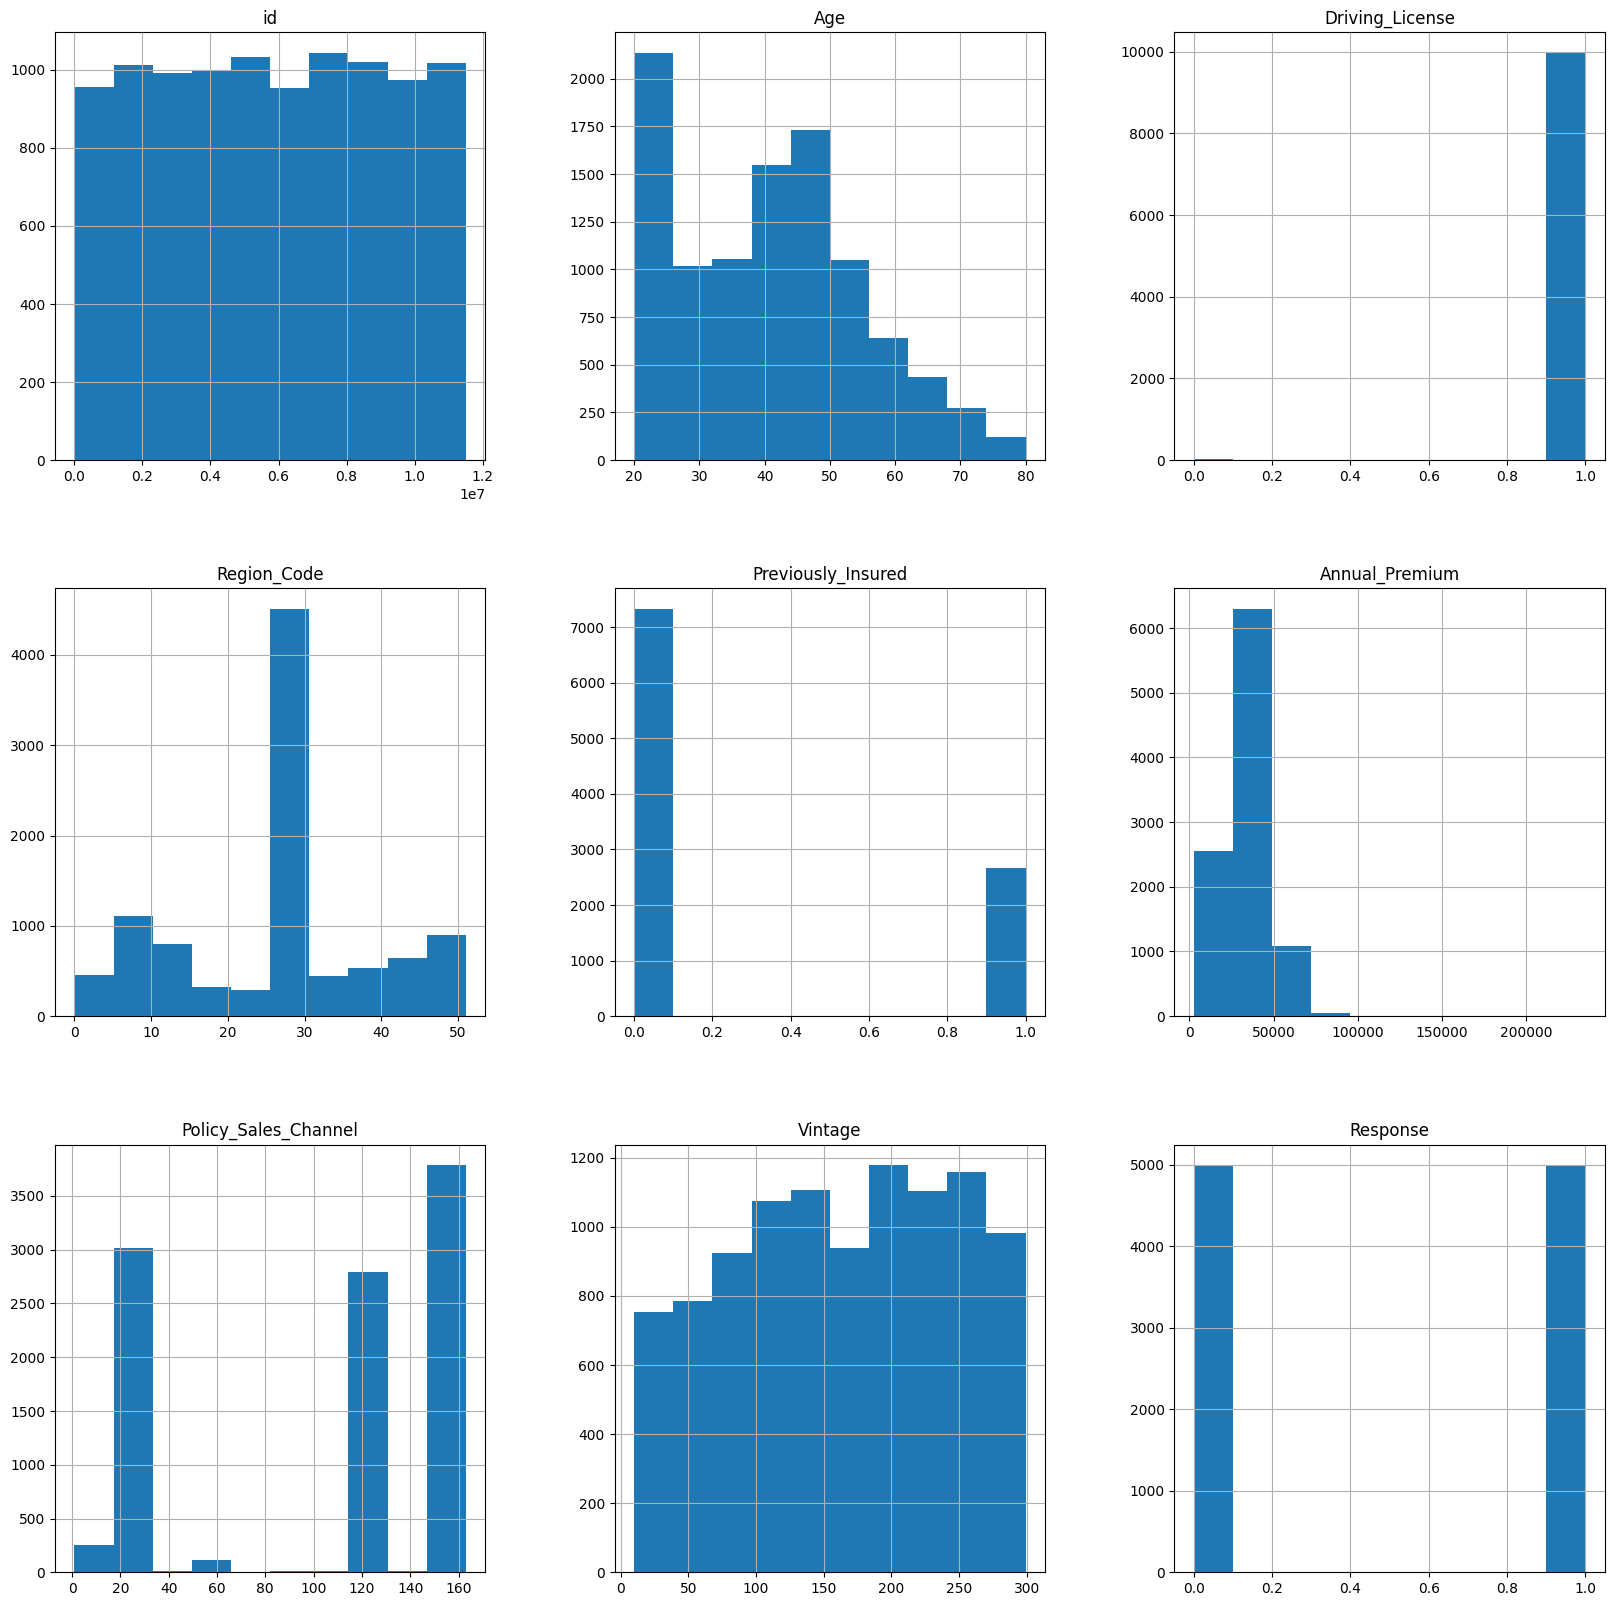

In [62]:
main_train.hist(figsize=(20,20))
plt.show()

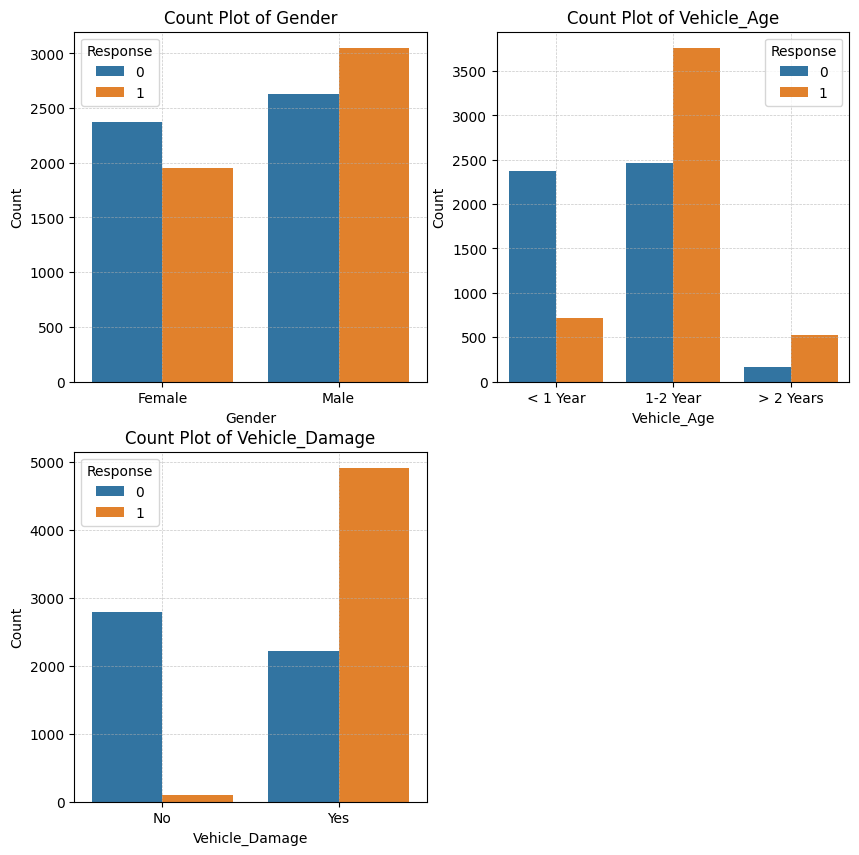

In [63]:
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

plt.figure(figsize=(10,10))
for i,feature in enumerate(categorical_features,1):
    plt.subplot(2, 2, i)
    sns.countplot(data=main_train,x = feature,hue = 'Response')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title(f'Count Plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show

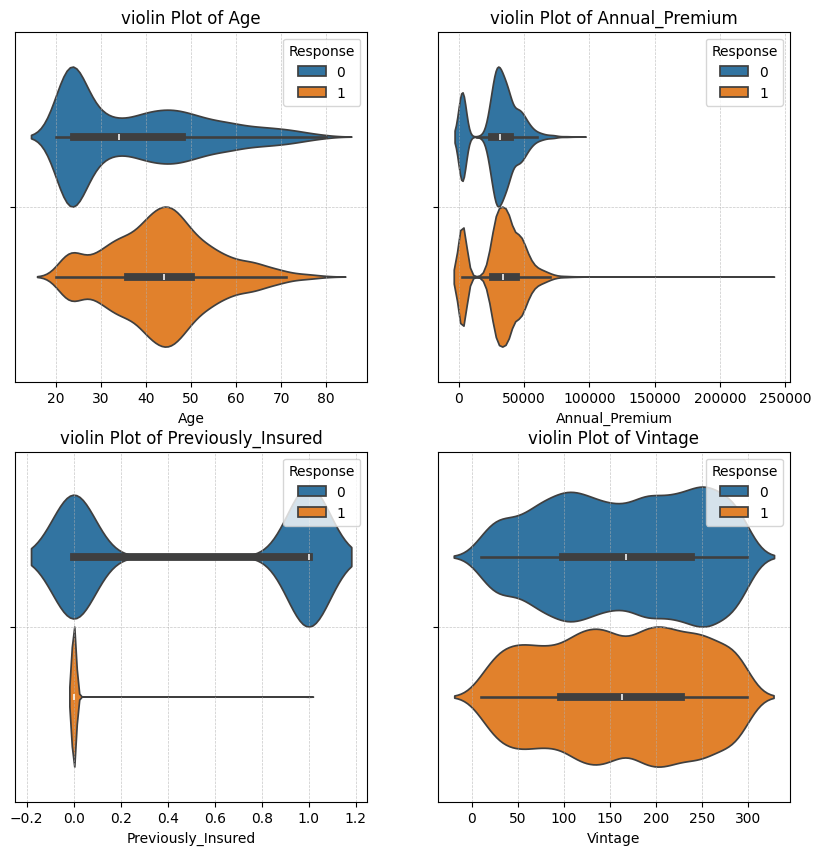

In [64]:
plt.figure(figsize=(10,10))
numerical_features = ['Age', 'Annual_Premium','Previously_Insured', 'Vintage']
for i,feature in enumerate(numerical_features,1):
    plt.subplot(2, 2, i)
    sns.violinplot(data=main_train,x = feature,hue = 'Response')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title(f'violin Plot of {feature}')
    plt.xlabel(feature)
    plt.show

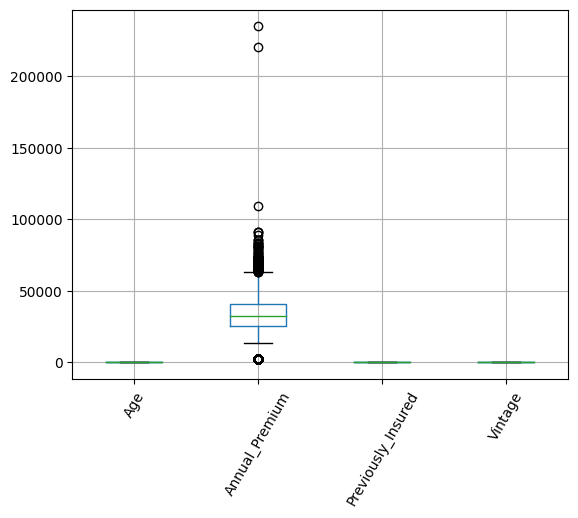

In [65]:
main_train[numerical_features].boxplot()
plt.xticks(rotation= 60)
plt.show()

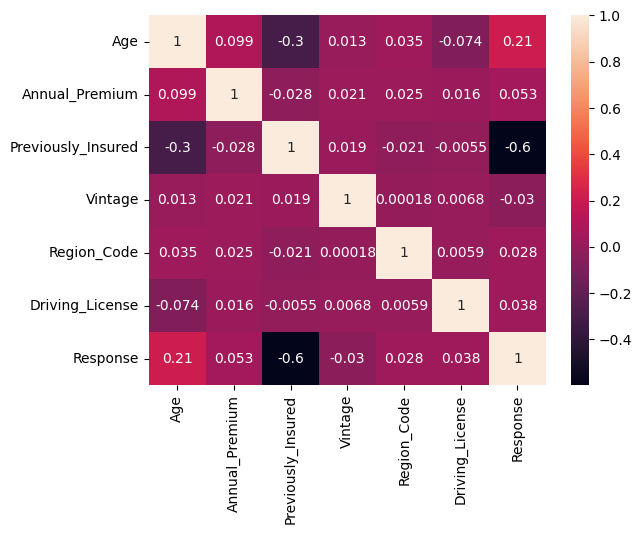

In [66]:


#plotting the heatmap for correlation
ax = sns.heatmap(main_train[['Age', 'Annual_Premium','Previously_Insured', 'Vintage', 'Region_Code','Driving_License','Response']].corr(), annot=True)

In [67]:
#Vehicle Age

main_train['Vehicle_Age'].unique()

array(['< 1 Year', '1-2 Year', '> 2 Years'], dtype=object)

In [68]:
main_train['Policy_Sales_Channel'].value_counts()

,count
Policy_Sales_Channel,
26.0,2824
124.0,2443
152.0,2318
160.0,369
156.0,365
...,...
136.0,1
135.0,1
140.0,1


In [69]:
main_train['Policy_Sales_Channel'].value_counts().nlargest(2)

,count
Policy_Sales_Channel,
26.0,2824
124.0,2443


### Mapping

In [70]:
data = main_train.copy()

In [71]:
class Mapper(BaseEstimator, TransformerMixin):
    """Categorical variable mapper."""

    def __init__(self, variables: str, mappings: dict):

        if not isinstance(variables, str):
            raise ValueError("variables should be a str")

        self.variables = variables
        self.mappings = mappings

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        # we need the fit statement to accomodate the sklearn pipeline
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        #for feature in self.variables:
        X[self.variables] = X[self.variables].map(self.mappings).astype(int)

        return X




In [72]:
map_vehicle_age=Mapper('Vehicle_Age',{'< 1 Year': 0, '1-2 Year': 1,'> 2 Years':2})
map_vehicle_damage=Mapper('Vehicle_Damage',{'Yes': 1, 'No': 0})
map_gender=Mapper('Gender', {'Male': 0, 'Female': 1} )


In [73]:

for i in [map_vehicle_age,map_vehicle_damage,map_gender]:
  data=i.fit(data).transform(data)

In [74]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,10728018,1,25,1,41.0,1,0,0,24783.0,152.0,260,0
1,6350115,0,49,1,7.0,0,1,1,27258.0,4.0,123,0
2,10726285,0,46,1,1.0,0,1,1,2630.0,156.0,30,0
3,3831797,0,51,1,28.0,0,1,1,43505.0,124.0,208,0
4,3810753,1,28,1,33.0,1,0,0,2630.0,152.0,39,0


### Column Dropper Class

In [75]:
class ColumnDropperTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        df = X.copy()
        df.drop(columns=self.columns,inplace=True, axis=1)
        return df


    def fit(self, X, y=None):
        return self

In [76]:
col_dropper = ColumnDropperTransformer(['id'])

data = col_dropper.fit(data).transform(data)
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,25,1,41.0,1,0,0,24783.0,152.0,260,0
1,0,49,1,7.0,0,1,1,27258.0,4.0,123,0
2,0,46,1,1.0,0,1,1,2630.0,156.0,30,0
3,0,51,1,28.0,0,1,1,43505.0,124.0,208,0
4,1,28,1,33.0,1,0,0,2630.0,152.0,39,0


### Feature Engineering

In [77]:
new_feature = 'is_young_driver'
data[new_feature] = ((data['Age'] >= 20) & (data['Age'] < 25)).astype('int8')

new_feature = 'is_old_driver'
data[new_feature] = (data['Age'] > 61).astype('int8')

In [78]:
class AgeColTransformer(BaseEstimator, TransformerMixin):

  """Age column transformer"""

  def __init__(self, feature):
    if not isinstance(feature, str):
      raise ValueError('variables should be a str')
    self.feature = feature

  def fit(self, X: pd.DataFrame, y=None):
    return self

  def transform(self, X):
    X = X.copy() # so that we do not over-write the original dataframe
    new_feature1 = 'is_young_driver'
    X[new_feature1] = ((X[self.feature] >= 20) & (X[self.feature] < 25)).astype('int64')

    new_feature2 = 'is_old_driver'
    X[new_feature2] = (X[self.feature] > 61).astype('int64')
    return X

In [79]:
  age_col_transformer = AgeColTransformer('Age')
  data = age_col_transformer.fit(data).transform(data)

In [80]:
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_young_driver,is_old_driver
0,1,25,1,41.0,1,0,0,24783.0,152.0,260,0,0,0
1,0,49,1,7.0,0,1,1,27258.0,4.0,123,0,0,0
2,0,46,1,1.0,0,1,1,2630.0,156.0,30,0,0,0
3,0,51,1,28.0,0,1,1,43505.0,124.0,208,0,0,0
4,1,28,1,33.0,1,0,0,2630.0,152.0,39,0,0,0


In [81]:
data['is_young_driver'].value_counts()

,count
is_young_driver,
0,8243
1,1757


In [82]:
data['is_old_driver'].value_counts()

,count
is_old_driver,
0,9171
1,829


In [83]:
data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_young_driver,is_old_driver
0,1,25,1,41.0,1,0,0,24783.0,152.0,260,0,0,0
1,0,49,1,7.0,0,1,1,27258.0,4.0,123,0,0,0
2,0,46,1,1.0,0,1,1,2630.0,156.0,30,0,0,0
3,0,51,1,28.0,0,1,1,43505.0,124.0,208,0,0,0
4,1,28,1,33.0,1,0,0,2630.0,152.0,39,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,63,1,28.0,0,1,1,44700.0,26.0,144,1,0,1
9996,1,46,1,30.0,0,1,1,28108.0,124.0,180,1,0,0
9997,0,37,1,28.0,0,1,1,46816.0,122.0,34,1,0,0
9998,0,36,1,28.0,0,1,1,24595.0,154.0,64,1,0,0


### Test and Train Split

In [89]:
# YOUR CODE HERE
x=data.drop('Response', axis=1)
y=data['Response']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((8000, 12), (2000, 12))

In [90]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                8000 non-null   int64  
 1   Age                   8000 non-null   int64  
 2   Driving_License       8000 non-null   int64  
 3   Region_Code           8000 non-null   float64
 4   Previously_Insured    8000 non-null   int64  
 5   Vehicle_Age           8000 non-null   int64  
 6   Vehicle_Damage        8000 non-null   int64  
 7   Annual_Premium        8000 non-null   float64
 8   Policy_Sales_Channel  8000 non-null   float64
 9   Vintage               8000 non-null   int64  
 10  is_young_driver       8000 non-null   int64  
 11  is_old_driver         8000 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 812.5 KB


In [91]:
X_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,is_young_driver,is_old_driver
9254,0,33,1,33.0,0,1,1,30399.0,124.0,178,0,0
1561,0,59,1,28.0,0,2,1,38314.0,124.0,100,0,0
1670,1,21,1,39.0,1,0,0,2630.0,152.0,42,1,0
6087,1,49,1,41.0,0,1,1,27162.0,26.0,122,0,0
6669,1,50,1,28.0,0,2,1,40299.0,124.0,57,0,0


In [92]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled[0,:]

x_test_scaled = scaler.transform(X_test)
x_test_scaled[0,:]

array([-0.8781156 ,  0.97163117,  0.04034408,  1.61454303, -0.60122407,
        2.20613109,  0.63502959, -0.33277307, -0.19411413, -0.22771689,
       -0.46653619, -0.29936826])

### Random Forest Classifier

In [93]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators = 150, max_depth = 5,random_state = 42)
# Fit the model
model_rf.fit(X_train_scaled, y_train)

# Predict the model
y_pred = model_rf.predict(x_test_scaled)

# Calculate the accuracy
print("Accuracy(in %):", accuracy_score(y_test, y_pred)*100)
print("F1-score(in %):", f1_score(y_test, y_pred)*100)

Accuracy(in %): 79.55
F1-score(in %): 81.99031263760457


In [101]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1012
           1       0.73      0.94      0.82       988

    accuracy                           0.80      2000
   macro avg       0.82      0.80      0.79      2000
weighted avg       0.82      0.80      0.79      2000



### XGBoost Classifer

In [99]:

#Creating an XGBoost classifier
model = xgb.XGBClassifier()

#Training the model on the training data
model.fit(X_train, y_train)

#Making predictions on the test set
predictions = model.predict(X_test)



# Calculate the accuracy
print("Accuracy(in %):", accuracy_score(y_test, predictions)*100)
print("F1-score(in %):", f1_score(y_test, predictions)*100)



Accuracy(in %): 79.3
F1-score(in %): 80.86876155268023


In [100]:
print("\nClassification Report:")
print(classification_report(y_test, predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      1012
           1       0.74      0.89      0.81       988

    accuracy                           0.79      2000
   macro avg       0.80      0.79      0.79      2000
weighted avg       0.80      0.79      0.79      2000



### Using the Random Forest Classfier as it having a better F1 score for the model deployment

### Build Pipeline

In [84]:
# YOUR CODE HERE

cross_sell_pipeline = Pipeline([

    ('map_vehicle_age',Mapper('Vehicle_Age',{'< 1 Year': 0, '1-2 Year': 1,'> 2 Years':2})),
    ('map_vehicle_damage',Mapper('Vehicle_Damage',{'Yes': 1, 'No': 0})),
    ('map_gender',Mapper('Gender', {'Male': 0, 'Female': 1} )),
    ('age_col_transform', AgeColTransformer('Age')),
    ('unused_column_dropper',ColumnDropperTransformer(['id','Driving_License'])),
    # scale
    ('scaler', StandardScaler()),
    # Model fit
    ('model_rf', RandomForestClassifier(n_estimators=150, max_depth=10,random_state=42))
])

### Train and test split of the original df to test the complete pipeline

In [102]:
# YOUR CODE HERE
x=main_train.drop('Response', axis=1)
y=main_train['Response']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((8000, 11), (2000, 11))

In [103]:
cross_sell_pipeline.fit(X_train, y_train)

Pipeline(steps=[('map_vehicle_age',
                 Mapper(mappings={'1-2 Year': 1, '< 1 Year': 0, '> 2 Years': 2},
                        variables='Vehicle_Age')),
                ('map_vehicle_damage',
                 Mapper(mappings={'No': 0, 'Yes': 1},
                        variables='Vehicle_Damage')),
                ('map_gender',
                 Mapper(mappings={'Female': 1, 'Male': 0}, variables='Gender')),
                ('age_col_transform', AgeColTransformer(feature='Age')),
                ('unused_column_dropper',
                 ColumnDropperTransformer(columns=['id', 'Driving_License'])),
                ('scaler', StandardScaler()),
                ('model_rf',
                 RandomForestClassifier(max_depth=10, n_estimators=150,
                                        random_state=42))])

In [104]:
y_pred = cross_sell_pipeline.predict(X_test)

In [106]:
# Calculate the accuracy
print("Accuracy(in %):", accuracy_score(y_test, y_pred)*100)
print("F1-score(in %):", f1_score(y_test, y_pred)*100)

Accuracy(in %): 79.4
F1-score(in %): 81.89806678383128


In [107]:
joblib.dump(cross_sell_pipeline,'cross_sell_pip.joblib')

['cross_sell_pip.joblib']